In [1]:
import time
import numpy as np
from tqdm import tqdm
import pandas as pd
import scipy as sp
from theano import tensor as tt
import pymc as pm
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax import jit
from jax.scipy.stats import norm

import jax.numpy as jnp
from jax import jit
from functools import partial 
import numpy as np
import scipy as sp
from jax.scipy.stats import norm
from jax.scipy.special import logsumexp

# from run_scripts.load_data import load_traintest_hier
# from conformal_bayes import conformal_Bayes_functions as cb
# from conformal_bayes import Bayes_MCMC_functions as bmcmc
%reload_ext autoreload
%autoreload 2

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


# BCP functions

## BCP in Full conformal prediciton 

```mermaid
flowchart TD
    A[Start: Training Data & Test Point] --> B[Fit Bayesian Model]
    B --> C[Generate Posterior Samples θ]
    C --> D[Define Grid of Potential y Values]
    
    D --> E[For Each Candidate y Value]
    
    subgraph candidate_loop ["Candidate y Loop"]
        E1[Compute Log Likelihood for Each Training Point] --> E2[Compute Log Likelihood for Candidate y Value]
        E2 --> E3[Create Augmented Dataset with Candidate y]
        E3 --> E4[Compute Conformity Scores & Normalized Ranks]
        E4 --> E5[Determine if y is in Conformal Set]
    end
    
    E --> candidate_loop
    candidate_loop --> F[Collect All y Values in Conformal Set]
    
    F --> G["Output: Conformal Prediction Interval with 1-α Coverage Guarantee"]

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
np.random.seed(42)

# ------------------- Step 1: Generate synthetic data -------------------
# Create a simple 1D regression problem
n_train = 50  # Number of training points
n_test = 1     # Number of test points

# Generate input features
X_train = np.random.uniform(-5, 5, n_train).reshape(-1, 1)
X_test = np.array([3.0]).reshape(-1, 1)  # Single test point

# True function: f(x) = sin(x) + some noise
def true_function(x):
    return 3*x+1

# Generate noisy observations
noise_level = 0.3
y_train = true_function(X_train) + np.random.normal(0, noise_level, size=X_train.shape)
y_true_test = true_function(X_test)[0]  # True value for the test point (we'll hide this)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ------------------- Step 2: Fit Bayesian Model -------------------
# We'll use a Bayesian Ridge Regression model from scikit-learn
bayesian_model = BayesianRidge(compute_score=True)
bayesian_model.fit(X_train_scaled, y_train)

# ------------------- Step 3: Generate Posterior Samples -------------------
# In a Bayesian Ridge model, the posterior is Gaussian
# We'll sample from the posterior distribution of the model
n_samples = 500

# Extract posterior mean and covariance for the coefficients
coef_mean = bayesian_model.coef_
intercept_mean = bayesian_model.intercept_
sigmas = np.sqrt(bayesian_model.sigma_)

# Function to sample from the posterior predictive distribution
def sample_posterior_predictive(X, n_samples):
    n_features = X.shape[1]
    
    # Sample model parameters from posterior
    coefs = np.random.normal(coef_mean, sigmas, size=(n_samples, n_features))
    intercepts = np.random.normal(intercept_mean, sigmas, size=n_samples)
    
    # Compute predictions for all samples
    predictions = []
    for i in range(n_samples):
        pred = np.dot(X, coefs[i]) + intercepts[i]
        predictions.append(pred)
    
    # Add noise for each prediction according to model's noise estimate
    alpha_noise = 1.0 / bayesian_model.alpha_
    noise = np.random.normal(0, np.sqrt(alpha_noise), size=(n_samples, len(X)))
    
    return np.array(predictions) + noise

# ------------------- Step 4: Define Grid of Potential y Values -------------------
# Define potential y values around model predictions
y_pred_mean = bayesian_model.predict(X_test_scaled)[0]
y_pred_std = np.sqrt(bayesian_model.predict(X_test_scaled, return_std=True)[1][0])

# Create grid of potential y values (covering approx. ±4 standard deviations)
y_grid = np.linspace(y_pred_mean - 4*y_pred_std, y_pred_mean + 4*y_pred_std, 100)

/opt/anaconda3/envs/BCP/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [4]:
# ------------------- Step 5-6: BCP Algorithm Core -------------------
# Set desired confidence level
alpha = 0.05  # 95% confidence level

# Function to compute log-likelihood for a data point
def compute_log_likelihood(X, y, coefs, intercept, noise_var):
    mean_pred = np.dot(X, coefs) + intercept
    return stats.norm.logpdf(y, loc=mean_pred, scale=np.sqrt(noise_var))

# Initialize array to store conformity scores for each candidate y
conformity_scores = {}
in_conformal_set = []

# Generate posterior samples for coefficients and predictions
posterior_samples = []
for i in range(n_samples):
    coefs = np.random.normal(coef_mean, sigmas)
    intercept = np.random.normal(intercept_mean, sigmas)
    posterior_samples.append((coefs, intercept))

# Compute noise variance from the model
noise_var = 1.0 / bayesian_model.alpha_

# Process each candidate y-value
for y_candidate in y_grid:
    # For each posterior sample
    sample_scores = []
    
    for coefs, intercept in posterior_samples:
        # Compute log-likelihoods for training points
        train_log_liks = [compute_log_likelihood(X_train_scaled[i], y_train[i], 
                                                coefs, intercept, noise_var) 
                          for i in range(len(X_train_scaled))]
        
        # Compute log-likelihood for the test point with candidate y
        test_log_lik = compute_log_likelihood(X_test_scaled[0], y_candidate, 
                                             coefs, intercept, noise_var)
        
        # Use negative log-likelihood as non-conformity score (smaller is more conforming)
        all_scores = [-ll for ll in train_log_liks + [test_log_lik]]
        
        # Compute rank of the test point (last element)
        test_score = all_scores[-1]
        rank = sum(1 for s in all_scores if s <= test_score) / len(all_scores)
        sample_scores.append(rank)
    
    # Average rank across posterior samples
    avg_rank = np.mean(sample_scores)
    conformity_scores[y_candidate] = avg_rank
    
    # Determine if y is in the conformal set
    if avg_rank > alpha:
        in_conformal_set.append(y_candidate)

# Convert to numpy array for easier analysis
in_conformal_set = np.array(in_conformal_set)

# ------------------- Step 7: Results -------------------
# Compute the prediction interval
pred_interval = (min(in_conformal_set), max(in_conformal_set))

print(f"True test value: {y_true_test[0]:.4f}")
print(f"Bayesian point prediction: {y_pred_mean:.4f}")
print(f"Bayesian Interval: [{y_pred_mean - 1.96*y_pred_std:.4f}, {y_pred_mean + 1.96*y_pred_std:.4f}]")
print(f"BCP {100*(1-alpha)}% interval: [{pred_interval[0]:.4f}, {pred_interval[1]:.4f}]")
print(f"BCP Interval width: {pred_interval[1] - pred_interval[0]:.4f}")


True test value: 10.0000
Bayesian point prediction: 9.9752
Bayesian Interval: [8.9397, 11.0107]
BCP 95.0% interval: [7.8619, 12.0884]
BCP Interval width: 4.2265


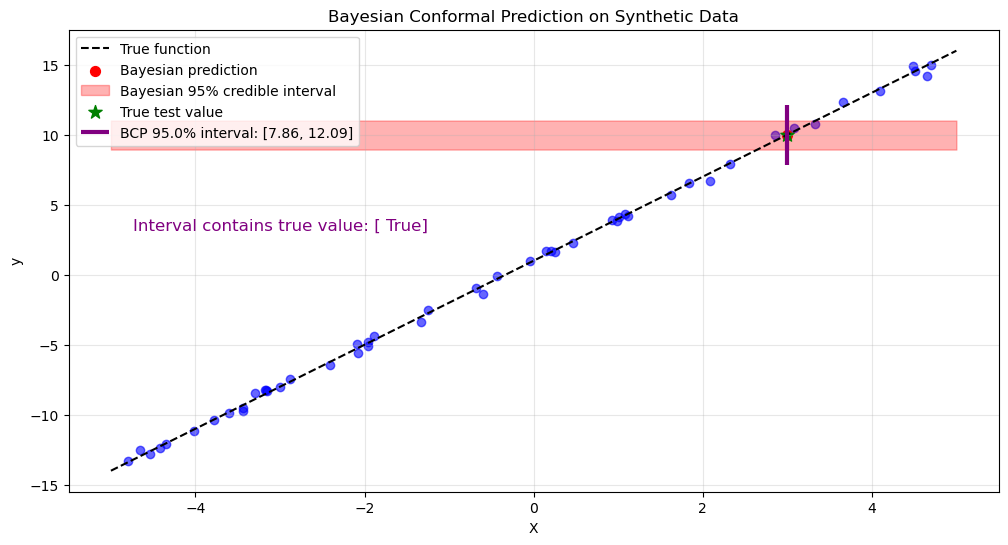

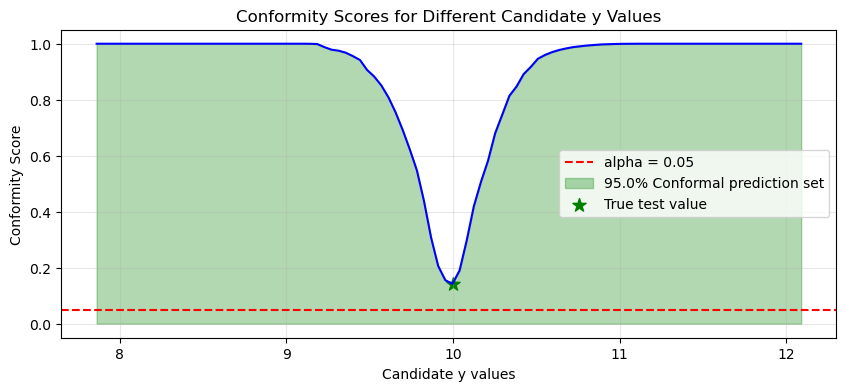

In [5]:
# Plot the results
plt.figure(figsize=(12, 6))

# Plot training data
plt.scatter(X_train, y_train, color='blue', alpha=0.6) # Training data points

# Plot true function
x_plot = np.linspace(-5, 5, 1000).reshape(-1, 1)
plt.plot(x_plot, true_function(x_plot), 'k--', label='True function')

# Plot model prediction
y_pred = bayesian_model.predict(X_test_scaled)
plt.scatter(X_test, y_pred, color='red', s=50, label='Bayesian prediction')

# Plot prediction intervals
plt.fill_between(x_plot.ravel(), 
                 y_pred - 1.96 * y_pred_std,
                 y_pred + 1.96 * y_pred_std,
                 alpha=0.3, color='red', label='Bayesian 95% credible interval')

# Plot test point and conformal interval
plt.scatter(X_test, y_true_test, color='green', s=100, marker='*', label='True test value')
plt.vlines(X_test, pred_interval[0], pred_interval[1], color='purple', linewidth=3, 
           label=f'BCP {100*(1-alpha)}% interval: [{pred_interval[0]:.2f}, {pred_interval[1]:.2f}]')

# Add annotation showing the interval contains the true value
contains_true = pred_interval[0] <= y_true_test <= pred_interval[1]
plt.annotate(f"Interval contains true value: {contains_true}",
             xy=(-3, 3),
             ha='center', va='bottom', fontsize=12, color='purple')

plt.title('Bayesian Conformal Prediction on Synthetic Data')
plt.xlabel('X')
plt.ylabel('y')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

# Plot the conformity scores for different candidate y values
plt.figure(figsize=(10, 4))
y_candidates = list(conformity_scores.keys())
scores = list(conformity_scores.values())
plt.plot(y_candidates, scores, 'b-')
plt.axhline(y=alpha, color='r', linestyle='--', label=f'alpha = {alpha}')
plt.fill_between(y_candidates, 0, scores, where=[s > alpha for s in scores], 
                 alpha=0.3, color='green', label=f'{100*(1-alpha)}% Conformal prediction set')
plt.scatter(y_true_test, conformity_scores.get(min(y_candidates, key=lambda y: abs(y - y_true_test)), 0), 
            color='green', s=100, marker='*', label='True test value')
plt.title('Conformity Scores for Different Candidate y Values')
plt.xlabel('Candidate y values')
plt.ylabel('Conformity Score')
plt.legend()
plt.grid(True, alpha=0.3)

### Fig 1:
**Bayesian Credible Intervals (Pink Shaded Area)**:

These are derived directly from the posterior distribution of the Bayesian Ridge model
They express the range where the model believes the true function value lies with 95% probability
They rely entirely on model assumptions (prior + likelihood)
Their interpretation is: "Given our model and data, there's a 95% probability that the true function value lies in this range"
These intervals can be miscalibrated if the model is misspecified

**Bayesian Conformal Prediction (BCP) Interval (Purple Vertical Line)**:

This combines Bayesian methods with conformal prediction
It uses the distribution of prediction errors on training data to calibrate the interval
It provides a theoretical coverage guarantee regardless of whether the model is correct
Its interpretation is: "With 95% confidence, future observations will fall in this range"
The BCP interval tends to be wider because it accounts for both model uncertainty and the distribution of errors

### Fig 2:
Values above the red dashed line (alpha threshold) are included in the conformal prediction set. 

##  'add-one-in' (AOI) importance sampling

```mermaid
flowchart TD
    A[Fit Bayesian Model] --> B[Extract Posterior Parameters]
    B --> C["For each candidate y-value"]
    C --> D[Generate Posterior Samples]
    D --> E[Compute Log-likelihoods for Training Points]
    E --> F[Compute Log-likelihood for Test Point with y]
    F --> G[Convert to Importance Weights]
    G --> H[Compute Predictive Probabilities]
    H --> I[Calculate Conformity Score/Rank]
    I --> J{"Rank > alpha * (n+1)?"}
    J -->|Yes| K[Include y in Conformal Set]
    J -->|No| L[Exclude y from Conformal Set]
    K --> M[Return Min/Max of Conformal Set]
    L --> C
    C -->|Done| N[Compute ESS & Diagnostics]
    M --> O[Visualize Results]
    N --> O

In [6]:
## CONFORMAL FROM MCMC SAMPLES ##
### JAX IMPLEMENTATION
@jit #compute rank (unnormalized by n+1)
def compute_rank_IS(logp_samp_n,logwjk):
    '''calculation of the rank function r(y) from equation (3) in Section 2.1, 
    which computes the rank of the conformity score for a new point 
    among all conformity scores'''
    n= jnp.shape(logp_samp_n)[1] #logp_samp_n is B x n
    n_plot = jnp.shape(logwjk)[0]
    rank_cp = jnp.zeros(n_plot)
    
    #compute importance sampling weights and normalizing
    wjk = jnp.exp(logwjk)
    Zjk = jnp.sum(wjk,axis = 1).reshape(-1,1)
    
    #compute predictives for y_i,x_i and y_new,x_n+1
    p_cp = jnp.dot(wjk/Zjk, jnp.exp(logp_samp_n))
    p_new = jnp.sum(wjk**2,axis = 1).reshape(-1,1)/Zjk

    #compute nonconformity score and sort
    pred_tot = jnp.concatenate((p_cp,p_new),axis = 1)
    rank_cp = np.sum(pred_tot <= pred_tot[:,-1].reshape(-1,1),axis = 1)
    return rank_cp


#compute region of grid which is in confidence set
@jit
def compute_cb_region_IS(alpha,logp_samp_n,logwjk): #assumes they are connected
    '''which values in a grid belong to the conformal prediction set Cα(Xn+1) from equation (3), 
    by checking which points have rank greater than α(n+1).'''
    n = jnp.shape(logp_samp_n)[1]#logp_samp_n is B x n
    rank_cp = compute_rank_IS(logp_samp_n,logwjk)
    region_true =rank_cp> alpha*(n+1)
    return region_true


## DIAGNOSE IMPORTANCE WEIGHTS ##
@jit #compute ESS/var
def diagnose_is_weights(logp_samp_n,logwjk):
    '''calculates diagnostics for the importance sampling weights, 
    specifically computing the effective sample size (ESS) 
    which is discussed in Section 4.1.1 of the paper and shown in Figure 1
    self-normalized weights as described in equations (5) and (6) in Section 2.2'''
    n= jnp.shape(logp_samp_n)[1] #logp_samp_n is B x n
    n_plot = jnp.shape(logwjk)[0]
    rank_cp = jnp.zeros(n_plot)
    
    #compute importance sampling weights and normalizing
    logwjk = logwjk.reshape(n_plot,-1, 1)
    logZjk = logsumexp(logwjk,axis = 1)
    
    #compute predictives for y_i,x_i and y_new,x_n+1
    logp_new = logsumexp(2*logwjk,axis = 1)-logZjk 

    #compute ESS
    wjk = jnp.exp(logwjk - logZjk.reshape(-1,1,1))
    ESS = 1/jnp.sum(wjk**2,axis = 1)

    #compute variance for p_new
    var = np.sum(wjk**2*(wjk - jnp.exp(logp_new).reshape(-1,1,1))**2,axis = 1)
    return ESS, var

In [7]:
import jax.numpy as jnp
from jax import jit
import numpy as np

# ------------------- Add-One-In Implementation -------------------
def run_add_one_in_bcp():
    # Extract model parameters
    coef_mean = bayesian_model.coef_
    intercept_mean = bayesian_model.intercept_
    sigmas = np.sqrt(bayesian_model.sigma_)
    noise_var = 1.0 / bayesian_model.alpha_
    
    n_train = len(X_train_scaled)
    n_samples = 500
    n_grid = len(y_grid)
    
    # Prepare matrices
    logp_samp_n = np.zeros((n_samples, n_train))
    logwjk = np.zeros((n_grid, n_samples))
    
    # Generate posterior samples and compute log-likelihoods
    for i in range(n_samples):
        # Sample from posterior
        coefs = np.random.normal(coef_mean, sigmas)
        intercept = np.random.normal(intercept_mean, sigmas[0])
        
        # Compute means for training points
        means_train = np.dot(X_train_scaled, coefs) + intercept
        
        # Compute log-likelihoods for training points
        for j in range(n_train):
            logp_samp_n[i, j] = stats.norm.logpdf(y_train[j], means_train[j], np.sqrt(noise_var))
        
        # Compute log-likelihood for test point with each candidate y
        mean_test = np.dot(X_test_scaled, coefs) + intercept
        for k in range(n_grid):
            logwjk[k, i] = stats.norm.logpdf(y_grid[k], mean_test[0], np.sqrt(noise_var))
    
    # Convert to JAX arrays for use with your functions
    logp_samp_n_jax = jnp.array(logp_samp_n)
    logwjk_jax = jnp.array(logwjk)
    
    # Use your functions to compute conformal regions
    alpha = 0.05
    in_conformal_set = compute_cb_region_IS(alpha, logp_samp_n_jax, logwjk_jax)
    ranks = compute_rank_IS(logp_samp_n_jax, logwjk_jax)
    
    # Convert to numpy for easier handling
    in_conformal_set = np.array(in_conformal_set)
    ranks = np.array(ranks)
    
    # Get the prediction interval
    conformal_indices = np.where(in_conformal_set)[0]
    if len(conformal_indices) > 0:
        min_idx, max_idx = np.min(conformal_indices), np.max(conformal_indices)
        pred_interval = (y_grid[min_idx], y_grid[max_idx])
    else:
        # Fallback if no points in conformal set
        pred_interval = (np.min(y_grid), np.max(y_grid))
    
    # Get diagnostics 
    ess, var = diagnose_is_weights(logp_samp_n_jax, logwjk_jax)
    ess = np.array(ess)
    var = np.array(var)
    
    return pred_interval, ranks, ess, var

# Run the Add-One-In BCP
pred_interval_aoi, ranks_aoi, ess, var = run_add_one_in_bcp()

print(f"True test value: {y_true_test[0]:.4f}")
print(f"Bayesian point prediction: {y_pred_mean:.4f}")
print(f"Bayeisan interval: [{y_pred_mean - 1.96*y_pred_std:.4f}, {y_pred_mean + 1.96*y_pred_std:.4f}]")
print(f"BCP {100*(1-alpha)}% interval: [{pred_interval_aoi[0]:.4f}, {pred_interval_aoi[1]:.4f}]")
print(f"BCP Interval width: {pred_interval_aoi[1] - pred_interval_aoi[0]:.4f}")


I0000 00:00:1743589503.714322       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


True test value: 10.0000
Bayesian point prediction: 9.9752
Bayeisan interval: [8.9397, 11.0107]
BCP 95.0% interval: [9.3561, 10.5942]
BCP Interval width: 1.2381


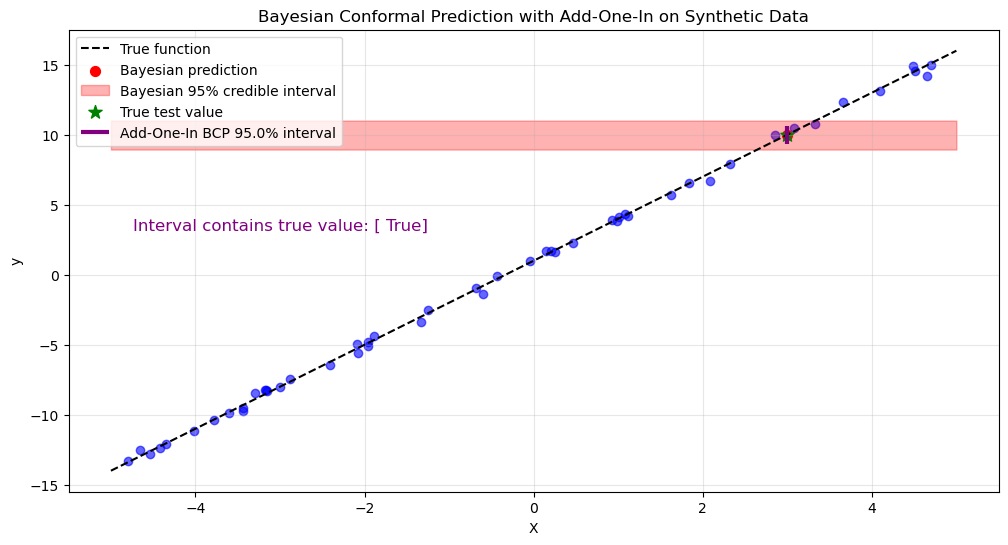

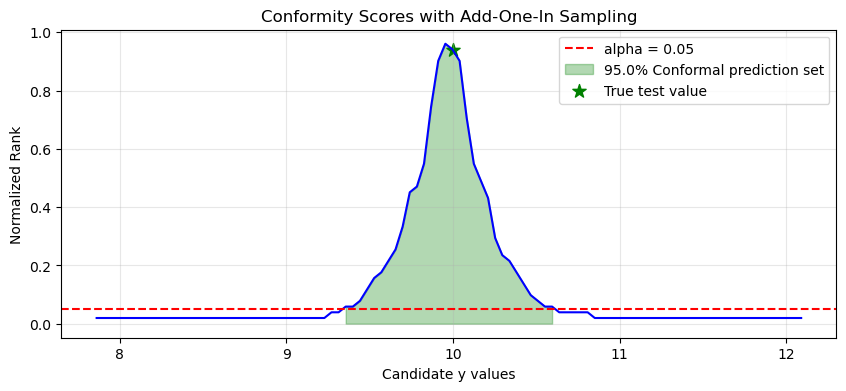

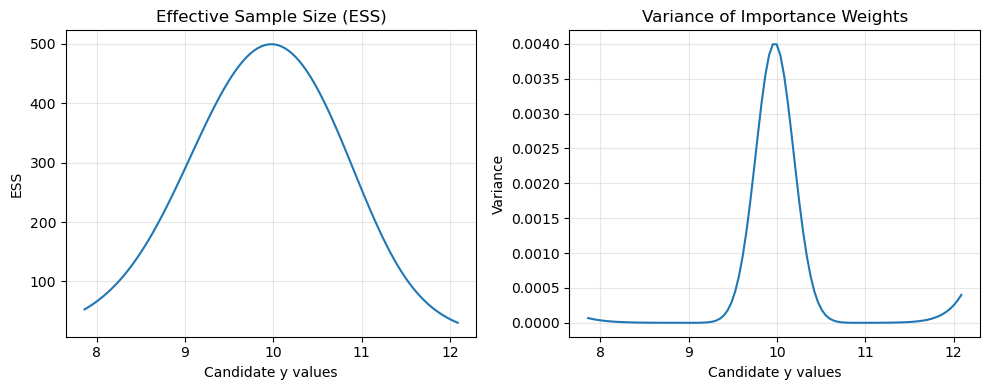

In [8]:
# Plot the results similar to your original plot
plt.figure(figsize=(12, 6))

# Plot training data
plt.scatter(X_train, y_train, color='blue', alpha=0.6)

# Plot true function
x_plot = np.linspace(-5, 5, 1000).reshape(-1, 1)
plt.plot(x_plot, true_function(x_plot), 'k--', label='True function')

# Plot model prediction
y_pred = bayesian_model.predict(X_test_scaled)
plt.scatter(X_test, y_pred, color='red', s=50, label='Bayesian prediction')

# Plot prediction intervals
plt.fill_between(x_plot.ravel(), 
                 y_pred - 1.96 * y_pred_std,
                 y_pred + 1.96 * y_pred_std,
                 alpha=0.3, color='red', label='Bayesian 95% credible interval')

# Plot test point and conformal interval
plt.scatter(X_test, y_true_test, color='green', s=100, marker='*', label='True test value')
plt.vlines(X_test, pred_interval_aoi[0], pred_interval_aoi[1], color='purple', linewidth=3, 
           label=f'Add-One-In BCP {100*(1-alpha)}% interval')

# Add annotation showing the interval contains the true value
contains_true = pred_interval_aoi[0] <= y_true_test <= pred_interval_aoi[1]
plt.annotate(f"Interval contains true value: {contains_true}",
             xy=(-3, 3),
             ha='center', va='bottom', fontsize=12, color='purple')

plt.title('Bayesian Conformal Prediction with Add-One-In on Synthetic Data')
plt.xlabel('X')
plt.ylabel('y')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.show()

# Plot the ranks for different candidate y values
plt.figure(figsize=(10, 4))
norm_ranks = ranks_aoi / (len(X_train) + 1)  # Normalize by n+1
plt.plot(y_grid, norm_ranks, 'b-')
plt.axhline(y=alpha, color='r', linestyle='--', label=f'alpha = {alpha}')
plt.fill_between(y_grid, 0, norm_ranks, where=norm_ranks > alpha, 
                 alpha=0.3, color='green', label=f'{100*(1-alpha)}% Conformal prediction set')
plt.scatter(y_true_test, np.interp(y_true_test, y_grid, norm_ranks), 
            color='green', s=100, marker='*', label='True test value')
plt.title('Conformity Scores with Add-One-In Sampling')
plt.xlabel('Candidate y values')
plt.ylabel('Normalized Rank')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot diagnostics for importance sampling
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(y_grid, ess)
plt.title('Effective Sample Size (ESS)')
plt.xlabel('Candidate y values')
plt.ylabel('ESS')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(y_grid, var)
plt.title('Variance of Importance Weights')
plt.xlabel('Candidate y values')
plt.ylabel('Variance')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Bayesian MCMC sampling

It computes the central (1-α) credible interval from the Bayesian posterior predictive CDF, as mentioned in Section 1 of the paper: "Alternatively, the central 100 × (1 − α)% credible interval can be computed using the α/2 and 1 − α/2 quantiles."

This is the standard Bayesian approach that the paper compares against the conformal Bayesian method. In Section 4.1, they mention: "We compute the central (1 − α) credible interval from the Bayesian posterior predictive CDF estimated using Monte Carlo and the same grid as for CB."

Unlike the conformal Bayesian intervals which have guaranteed frequentist coverage, these Bayesian intervals may not maintain the target coverage rate under model misspecification, as demonstrated in the experiments in the paper.

In [9]:
## BAYESIAN CREDIBLE INTERVALS FROM MCMC SAMPLES ##
#calculation of Bayesian predictive intervals 
# compute bayesian central 1-alpha credible interval
@jit
def compute_bayes_band_MCMC(alpha, y_plot, cdf_pred):
    cdf_pred = jnp.mean(cdf_pred, axis=1)
    
    # Find the indices for lower and upper bounds
    lower_idx = jnp.argmin(jnp.abs(cdf_pred - alpha/2))
    upper_idx = jnp.argmin(jnp.abs(cdf_pred - (1-alpha/2)))
    
    # Create the band with the corresponding y values
    band_bayes = jnp.array([y_plot[lower_idx], y_plot[upper_idx]])
    
    return band_bayes

In [10]:
import jax
import jax.numpy as jnp
from jax import jit
from jax.scipy.stats import norm

# ------------------- Bayesian MCMC Implementation -------------------
def run_bayesian_mcmc():
    # Extract model parameters
    coef_mean = bayesian_model.coef_
    intercept_mean = bayesian_model.intercept_
    sigmas = np.sqrt(bayesian_model.sigma_)
    noise_var = 1.0 / bayesian_model.alpha_
    
    n_samples = 500
    n_grid = len(y_grid)
    
    # Generate posterior samples
    samples_coef = np.random.normal(coef_mean, sigmas, size=(n_samples, len(coef_mean)))
    samples_intercept = np.random.normal(intercept_mean, sigmas[0], size=n_samples)
    
    # Compute CDF for each y in grid
    cdf_pred = np.zeros((n_grid, n_samples))
    
    # For each posterior sample
    for i in range(n_samples):
        # Get parameters for this sample
        coefs = samples_coef[i]
        intercept = samples_intercept[i]
        
        # Compute mean prediction at test point
        mean_pred = np.dot(X_test_scaled, coefs) + intercept
        
        # Compute CDF for each y value
        for j in range(n_grid):
            cdf_pred[j, i] = norm.cdf(y_grid[j], loc=mean_pred[0], scale=np.sqrt(noise_var))
    
    # Convert to JAX arrays
    y_plot_jax = jnp.array(y_grid)
    cdf_pred_jax = jnp.array(cdf_pred)
    
    # Compute Bayesian credible interval
    alpha = 0.05
    band_bayes = compute_bayes_band_MCMC(alpha, y_plot_jax, cdf_pred_jax)
    
    # Convert back to numpy
    band_bayes = np.array(band_bayes)
    
    return band_bayes

# Run the Bayesian MCMC
bayesian_interval = run_bayesian_mcmc()

# Compare with BCP interval
print(f"True test value: {y_true_test[0]:.4f}")
print(f"Bayesian 95% Credible Interval: [{bayesian_interval[0]:.4f}, {bayesian_interval[1]:.4f}]")
print(f"BCP 95% Prediction Interval: [{pred_interval_aoi[0]:.4f}, {pred_interval_aoi[1]:.4f}]")


True test value: 10.0000
Bayesian 95% Credible Interval: [9.3988, 10.5088]
BCP 95% Prediction Interval: [9.3561, 10.5942]


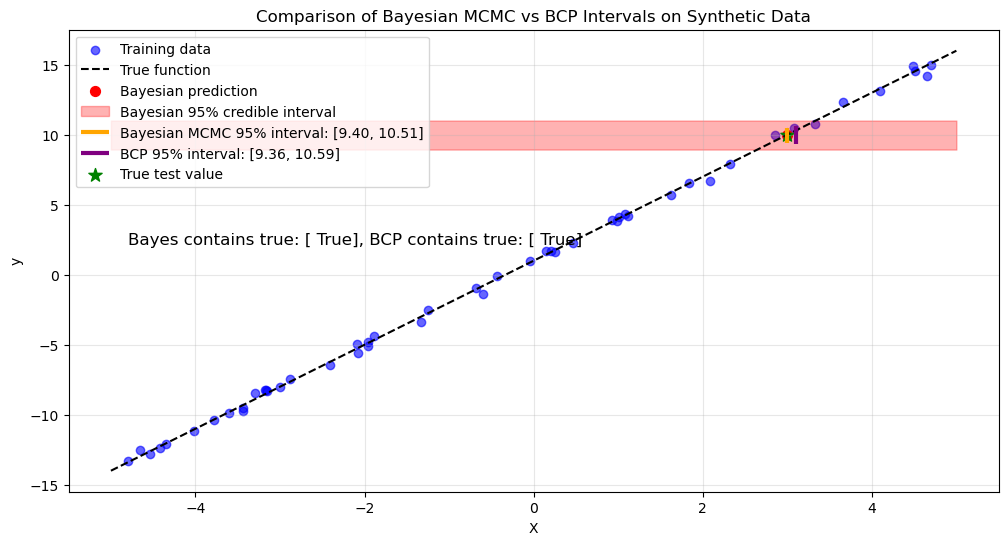

In [12]:
# Plot the results for comparison
plt.figure(figsize=(12, 6))

# Plot training data
plt.scatter(X_train, y_train, color='blue', alpha=0.6, label='Training data')

# Plot true function
x_plot = np.linspace(-5, 5, 1000).reshape(-1, 1)
plt.plot(x_plot, true_function(x_plot), 'k--', label='True function')

# Plot model prediction
y_pred = bayesian_model.predict(X_test_scaled)
plt.scatter(X_test, y_pred, color='red', s=50, label='Bayesian prediction')

# Plot Bayesian credible intervals
plt.fill_between(x_plot.ravel(), 
                 y_pred - 1.96 * y_pred_std,
                 y_pred + 1.96 * y_pred_std,
                 alpha=0.3, color='red', label='Bayesian 95% credible interval')

# Plot Bayesian MCMC interval at test point
plt.vlines(X_test, bayesian_interval[0], bayesian_interval[1], color='orange', linewidth=3, 
           label=f'Bayesian MCMC 95% interval: [{bayesian_interval[0]:.2f}, {bayesian_interval[1]:.2f}]')

# Plot BCP interval at test point
plt.vlines(X_test + 0.1, pred_interval_aoi[0], pred_interval_aoi[1], color='purple', linewidth=3, 
           label=f'BCP 95% interval: [{pred_interval_aoi[0]:.2f}, {pred_interval_aoi[1]:.2f}]')

# Plot test point
plt.scatter(X_test, y_true_test, color='green', s=100, marker='*', label='True test value')

# Add annotation showing which intervals contain the true value
contains_true_bayes = bayesian_interval[0] <= y_true_test <= bayesian_interval[1]
contains_true_bcp = pred_interval_aoi[0] <= y_true_test <= pred_interval_aoi[1]
plt.annotate(f"Bayes contains true: {contains_true_bayes}, BCP contains true: {contains_true_bcp}",
             xy=(-4.8, 3),
             ha='left', va='top', fontsize=12)

plt.title('Comparison of Bayesian MCMC vs BCP Intervals on Synthetic Data')
plt.xlabel('X')
plt.ylabel('y')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)